In [62]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

f = open('iris.names', mode='r')
read = f.read()
print(read)


1. Title: Iris Plants Database
	Updated Sept 21 by C.Blake - Added discrepency information

2. Sources:
     (a) Creator: R.A. Fisher
     (b) Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
     (c) Date: July, 1988

3. Past Usage:
   - Publications: too many to mention!!!  Here are a few.
   1. Fisher,R.A. "The use of multiple measurements in taxonomic problems"
      Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions
      to Mathematical Statistics" (John Wiley, NY, 1950).
   2. Duda,R.O., & Hart,P.E. (1973) Pattern Classification and Scene Analysis.
      (Q327.D83) John Wiley & Sons.  ISBN 0-471-22361-1.  See page 218.
   3. Dasarathy, B.V. (1980) "Nosing Around the Neighborhood: A New System
      Structure and Classification Rule for Recognition in Partially Exposed
      Environments".  IEEE Transactions on Pattern Analysis and Machine
      Intelligence, Vol. PAMI-2, No. 1, 67-71.
      -- Results:
         -- very low misclassification rates (0% for t

In [2]:
iris = np.loadtxt("iris.data",
   dtype={'names': ('sepal length', 'sepal width', 'petal length', 'petal width', 'Label'),
          'formats': (np.float, np.float, np.float, np.float, np.object)},
   delimiter=',', skiprows=0)
iris1 = pd.DataFrame(iris)
iris1.head()

,sepal length,sepal width,petal length,petal width,Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


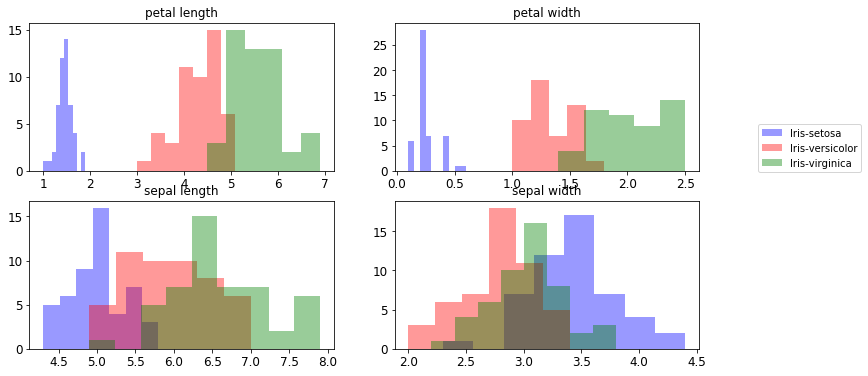

In [3]:
grp_col_dict = {'Iris-setosa': 'blue', 'Iris-versicolor': 'red', 'Iris-virginica': 'green'}

feature_columns = iris1.columns.difference(["Label"])
x = iris1[feature_columns]
y = iris1["Label"]

plt.figure(figsize=(12,6))

for i, fea in enumerate(feature_columns):
    plt.subplot(221+i)
    for group in grp_col_dict:
        subset = iris[iris['Label'] == group]
        sns.distplot(subset[fea], 
                        hist = True, kde = False, 
                        color = grp_col_dict[group], label=group)
    plt.title(fea)
plt.legend(bbox_to_anchor = (1.3,1.3,0.25,0.25))

In [55]:
def confusion(target, predict):
    if len(target)==len(predict):
        mat = pd.DataFrame({'target':list(target),'predicts':list(predict),'count':np.ones(len(target))})
        # 숫자를 세기 위해 1로 이루어진 열을 추가
        matg = mat.groupby([mat.target,mat.predicts]).sum().unstack("predicts")  #중복된 열을 합해 테이블 형식으로 만듬
        matg = matg.fillna(0) #빈공간은 0으로 채움
    else :
        print(len(target))
        print(len(predict))
        matg = "size is different!"  #사이즈가 다를 때 
    return np.array(matg)
def acc(cfmat):
    precision = np.zeros(shape=cfmat.shape[0])
    recall = np.zeros(shape=cfmat.shape[0])
    for  i in range(cfmat.shape[0]):
        pre , rec = 0 ,0
        pre = sum(cfmat[i,:])
        precision[i] = (cfmat[i,i]/pre) 
        rec = sum(cfmat[:,i])
        recall[i] = (cfmat[i,i]/rec)  #행과 열 합을 이용해 구함
    return precision.mean(), recall.mean()   #각각 구한 precision과 recall의 평균

In [5]:
thre1, thre2, thre3, thre4 = np.arange(4.35,5.36,0.1),np.arange(1.35,1.86,0.1),np.arange(5.05,6.56,0.1),np.arange(2.75,3.76,0.1)
threshold = thre1,thre2,thre3,thre4  #threshold 범위를 만들어 각각 계산 후 최적의 값 도출하기 위함
vvv1 = iris1[(iris1['Label']=="Iris-setosa")|(iris1['Label']=="Iris-versicolor")]
vvv2 = iris1[((iris1['Label']=="Iris-versicolor")|(iris1['Label']=="Iris-virginica"))]
vvv3 = iris1[(iris1['Label']=="Iris-setosa")|(iris1['Label']=="Iris-virginica")]  #라벨이 두개인 데이터 각각 생성
layer1, layer2, layer3 = [], [], []
print("versicolor vs virginica")
for u, fea in zip(threshold, feature_columns):
    print(fea)
    best_threshold=0
    best_score = 0
    table = pd.DataFrame(columns=['precision','recall'])
    for i in u:
        correct1 = []
        for a in vvv2[fea]: #값을 비교해 분류
            if i > a:
                correct1.append("Iris-versicolor")
            else:
                correct1.append("Iris-virginica")
        cfmat = confusion(vvv2["Label"],correct1)
        table.loc[i] = acc(cfmat) #정확도를 테이블에 저장
        #f1 score계산
        f1_score = (2*table.loc[i][0]*table.loc[i][1]) / (table.loc[i][0]+table.loc[i][1])
        if best_score < f1_score: # 더 좋은  결과가 나왔을 때 저장
            best_score = f1_score
            best_threshold = i
    print(table)
    layer1.append(best_threshold)

for u, fea in zip(threshold, feature_columns): #위의 과정과 비슷
    if (fea=="petal length")|(fea=="petal width"):
        layer2.append((vvv1[vvv1["Label"]=="Iris-versicolor"][fea].min()+vvv1[vvv1["Label"]=="Iris-setosa"][fea].max())/2)
        continue
    else:
        best_threshold=0
        best_score = 0
        table = pd.DataFrame(columns=['precision','recall'])
        for i in u:
            correct1 = []
            for a in vvv1[fea]:
                if fea != "sepal width":
                    if (i > a):
                        correct1.append("Iris-setosa")
                    else:
                        correct1.append("Iris-versicolor")
                else:
                    if (i < a):
                        correct1.append("Iris-setosa")
                    else:
                        correct1.append("Iris-versicolor")
            cfmat = confusion(vvv1["Label"],correct1)
            table.loc[i] = acc(cfmat)
            f1_score = (2*table.loc[i][0]*table.loc[i][1]) / (table.loc[i][0]+table.loc[i][1])
            if best_score < f1_score:
                best_score = f1_score
                best_threshold = i
        layer2.append(best_threshold)
        

for u, fea in zip(threshold, feature_columns): # 위의 가정과 비슷
    if (fea=="petal length")|(fea=="petal width"):
        layer3.append((vvv3[vvv3["Label"]=="Iris-virginica"][fea].min()+vvv3[vvv3["Label"]=="Iris-setosa"][fea].max())/2)
        continue
    else:
        best_threshold=0
        best_score = 0
        table = pd.DataFrame(columns=['precision','recall'])
        for i in u:
            correct1 = []
            for a in vvv3[fea]:
                if fea != "sepal width":
                    if (i > a):
                        correct1.append("Iris-setosa")
                    else:
                        correct1.append("Iris-versicolor")
                else:
                    if (i < a):
                        correct1.append("Iris-setosa")
                    else:
                        correct1.append("Iris-versicolor")
            cfmat = confusion(vvv3["Label"],correct1)
            table.loc[i] = acc(cfmat)
            f1_score = (2*table.loc[i][0]*table.loc[i][1]) / (table.loc[i][0]+table.loc[i][1])
            if best_score < f1_score:
                best_score = f1_score
                best_threshold = i
        layer3.append(best_threshold)
print(layer1)
print(layer2)
print(layer3)

versicolor vs virginica
petal length
      precision    recall
4.35       0.75  0.833333
4.45       0.79  0.852113
4.55       0.85  0.875375
4.65       0.88  0.895833
4.75       0.93  0.934343
4.85       0.93  0.930172
4.95       0.92  0.922705
5.05       0.90  0.910509
5.15       0.84  0.878788
5.25       0.82  0.867647
5.35       0.80  0.857143
petal width
      precision    recall
1.35       0.78  0.847222
1.45       0.84  0.868924
1.55       0.92  0.920673
1.65       0.94  0.940705
1.75       0.94  0.942834
1.85       0.84  0.878788
sepal length
      precision    recall
5.05       0.52  0.630208
5.15       0.53  0.657895
5.25       0.54  0.677305
5.35       0.54  0.677305
5.45       0.55  0.692012
5.55       0.60  0.736742
5.65       0.64  0.737127
5.75       0.68  0.746711
5.85       0.68  0.714286
5.95       0.69  0.714835
6.05       0.71  0.720681
6.15       0.73  0.732323
6.25       0.73  0.730092
6.35       0.70  0.705255
6.45       0.67  0.686813
6.55       0.64  0.666667
se

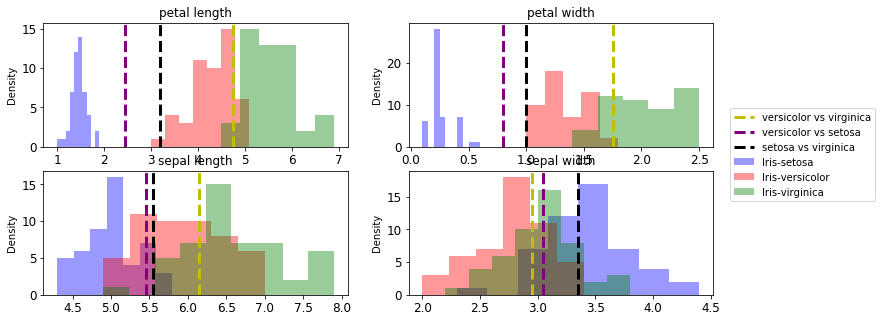

In [6]:
plt.figure(figsize=(12,5))

for i, fea in enumerate(feature_columns):
    plt.subplot(221+i)
    for group in grp_col_dict:
        subset = iris[iris['Label'] == group]
        sns.distplot(subset[fea], 
                        hist = True, kde = False, 
                        color = grp_col_dict[group], label=group)
    plt.axvline(layer1[i], color='y', linestyle='dashed', linewidth=3,label="versicolor vs virginica")
    plt.axvline(layer2[i], color='purple', linestyle='dashed', linewidth=3 ,label="versicolor vs setosa")
    plt.axvline(layer3[i], color='k', linestyle='dashed', linewidth=3, label="setosa vs virginica")
    plt.title(fea)
    plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.3,1.3,0.25,0.25))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


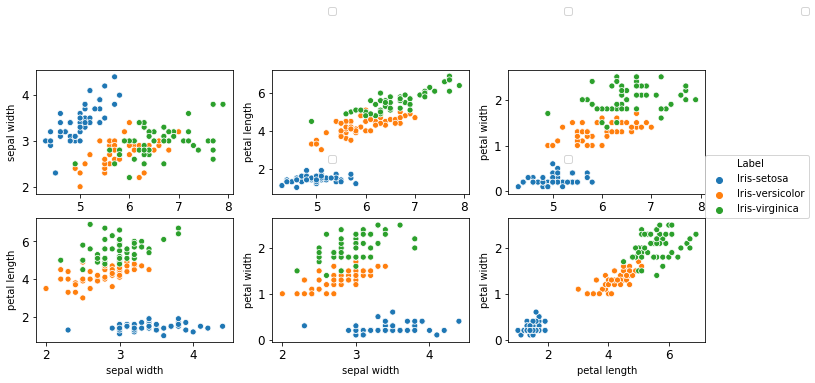

In [7]:
combine = []
for i in range(0,4):
    for j in range(0,4):
        vector1= []
        if (i==j)|(i>j):
            continue
        else:
            vector1.append(i)
            vector1.append(j)
            combine.append(vector1)
plt.figure(figsize=(12,5))

for i, com in enumerate(combine):
    plt.subplot(231+i)
    if i ==5:
        g = sns.scatterplot(iris1.iloc[:,com[0]],iris1.iloc[:,com[1]], hue = "Label",data=iris1)
    else:
        g = sns.scatterplot(iris1.iloc[:,com[0]],iris1.iloc[:,com[1]], hue = "Label",data=iris1,legend=False)
    plt.legend(bbox_to_anchor=(1.3,1.3,0.25,0.25))

In [76]:
a1, a2 = y.factorize()
max_iterations=10000
threshold=0.01
a3 = a1[0:100]
a4 = a1[50:150]
a4[50:100] = 0
a4[100:150] = 1
def sigmoid(x): 
    return 1/(1 + np.exp(-x))

def cost_f(h, y): 
    final = -y * np.log(h)  - (1 - y) * np.log(1 - h) 
    # 음수를 취해 값이 줄어들어 0에 가까워지는지 확인
    return final.mean()

def fit(x, y):
    W = np.zeros(x.shape[1])  #변수 개수만큼 weight추가
    for i in range(max_iterations):
        z = np.dot(x, W) #행렬곱
        hypothesis = sigmoid(z) 
        diff = (hypothesis - y) 
        cost = cost_f(hypothesis, y)  #손실 함수
        if cost < threshold: #어느정도 줄었을 경우 중단
            break
        gradient = np.dot(x.T, diff) / x.shape[0] 
        #likelihood를 미분한 식에 대입
        W -= 0.01 * gradient
    return W

X = np.concatenate((intercept, vvv1.iloc[:,[0,2]]), axis=1)
F = fit(X1,a3)

0.6931471805599453
0.5616702929009648
0.5236862866650459
0.48984535140245195
0.4591988829711213
0.4314189674546225
0.4062087194171253
0.3832970934755163
0.3624391165247829
0.3434150654442402
0.326028962077051
0.31010669859928586
0.2954940097068513
0.28205443559117094
0.26966736605160974
0.2582262177797977
0.2476367705136662
0.23781567037710377
0.228689097786706
0.2201915908645889
0.2122650118877003
0.20485764287896885
0.19792339626781152
0.1914211271138139
0.18531403436216481
0.17956913976471153
0.17415683431923182
0.16905048326925287
0.16422608182112644
0.159661954751133
0.1553384939848163
0.1512379290341921
0.14734412588160314
0.1436424105101482
0.14011941380918805
0.13676293503897397
0.133561821430055
0.1305058618292221
0.1275856925919247
0.12479271416804537
0.12211901703953648
0.11955731584980243
0.11710089072025409
0.11474353488294975
0.11247950787289485
0.11030349362216221
0.10821056288286975
0.1061961394792036
0.10425596995180902
0.10238609621243942
0.10058283087397349
0.0988427

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


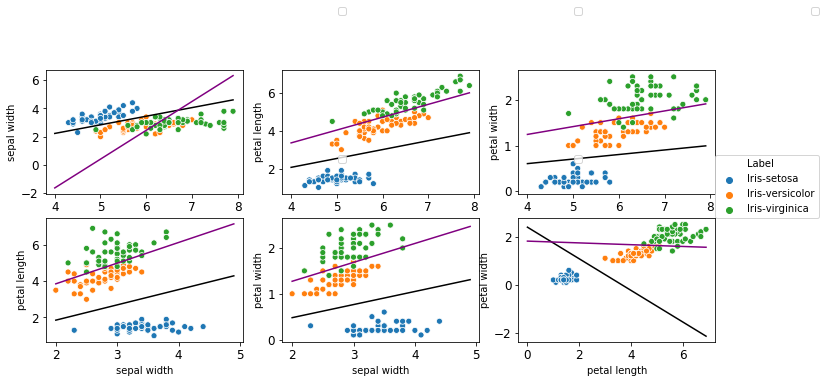

In [68]:
plt.figure(figsize=(12,5))
x4, x5,x6,x7,x8,x9= np.arange(4, 8, 0.1),np.arange(4, 8, 0.1) ,np.arange(4, 8, 0.1) ,np.arange(2, 5, 0.1) ,np.arange(2, 5, 0.1) ,np.arange(0, 7, 0.1)  
xx = x4,x5,x6,x7,x8,x9
pre1, pre2 = [], []
for i, com in enumerate(combine):
    plt.subplot(231+i)
    intercept = np.ones((vvv1.shape[0], 1))
    X1 = np.concatenate((intercept, vvv1.iloc[:,com]), axis=1) #y절편을 만듬
    X2 = np.concatenate((intercept, vvv2.iloc[:,com]), axis=1)
    S = fit(X1,a3)
    Q = fit(X2,a4)
    x1 = xx[i]
    x2 = -(S[0] + S[1]*x1)/S[2]  # 직선의 방정식
    x3 = -(Q[0] + Q[1]*x1)/Q[2]
    if i ==5:
        g = sns.scatterplot(iris1.iloc[:,com[0]],iris1.iloc[:,com[1]], hue = "Label",data=iris1)
    else:
        g = sns.scatterplot(iris1.iloc[:,com[0]],iris1.iloc[:,com[1]], hue = "Label",data=iris1,legend=False) 
    plt.legend(bbox_to_anchor=(1.3,1.3,0.25,0.25)) 
    plt.plot(x1, x2, c='k')
    plt.plot(x1, x3, c='purple')

In [11]:
import random
class Str_Kfold:
    np.random.seed(123)
    def __init__(self,k):
        self.k = k
    def str_random(self,y):
        y_counts = y.value_counts()
        num = 0
        prior_counts = 0
        random_list = []
        y_range = []
        foldk = []
        y_range = y_counts/ self.k
        for i in range(len(y_counts)):
            a = random.sample(list(np.arange(num,num+y_counts[i],1)),y_counts[i])
            # 각 범주의 개수만큼 랜덤넘버 생성
            for j in range(self.k):
                b = a[num-prior_counts:num-prior_counts+np.int(y_range[i])]
                #범주를 k개로 쪼개는 과정
                random_list.append(b)
                num += np.int(y_range[i])
            prior_counts = num
        for j in range(self.k):  # 각 범주의 j번째 요소만 모아 k개의 데이터로 만듬
            fold = []
            for i in range(len(y_counts)):
                fold.extend(random_list[(i*self.k)+j]) 
            foldk.append(fold)
        return foldk
    def cross_vali(self,x,y,classifier):
        fold = self.str_random(y)
        fu = []
        for k in range(self.k):
            train = []
            test = fold[k]  # k번째를 test로 정하고
            for j in range(self.k):
                if k==j:
                    continue
                else:
                    train.extend(fold[j]) # 나머지는 train이 됨
            set = pd.concat([x,y],axis=1)
            traink = set.iloc[train,:]
            testk = set.iloc[test,:]
            # 클래스별 fit함수를 이용해 작업을 수행
            fu.append(confusion(classifier.fit(traink,testk,y),testk["Label"]))
        return fu
strs = Str_Kfold(5)
y_trip = pd.Series(["g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","g","h","h","h","h","h","h","h","h",
                   "h","h","h","h","h","h","h","i","i","i","i","i","i","i","i","i","i","j","j","j","j","j",])
strs.str_random(y_trip)

[[3, 9, 4, 14, 30, 23, 20, 42, 38, 48],
 [5, 18, 10, 2, 21, 32, 29, 35, 37, 49],
 [0, 7, 13, 11, 33, 28, 24, 39, 36, 47],
 [1, 12, 8, 6, 26, 22, 25, 43, 41, 45],
 [15, 17, 19, 16, 31, 34, 27, 44, 40, 46]]

In [12]:
columns1= ['Iris-setosa','Iris-versicolor','Iris-virginica']
class PmfClassifier:
    #def Multinomial_fun (self,x):
        
    def posterior_fun(self, w,x, xprior):
        pos_list = []
        for i in range(len(x)):
            pos = 0
            for j in range(len(xprior)):
                t = xprior[i].index[j]
                if x[i] != t:
                    continue
                else:
                    pos = (xprior[i][t]+1)/(w+1)  # test값의 확률을 구함
                    break
            if pos ==0:
                pos = 1/(w+1)
            pos_list.append(pos)
        return pos_list
    def fit(self, traink,testk,y):
        prior = traink["Label"].value_counts()
        posterior = pd.DataFrame(columns =  np.unique(y))
        xprior = []
        for j, col in enumerate(columns1):
            vector1 = []
            for i in range(traink.shape[1]-1):
                g = traink.iloc[:,[i,-1]].groupby(y.name)[traink.iloc[:,i].name].value_counts()
                # 그룹별로 값의 빈도수 계산
                vector1.append(g[col])
            xprior.append(vector1)
        vector2=[]
        for j, col in enumerate(columns1):
            vector1=[]
            for row in range(testk.shape[0]):
                vector1.append(self.posterior_fun(prior[j], testk.iloc[row,:-1], xprior[j]))
            vector2.append(vector1) # 그룹별로 확률을 계산해 값의 빈도를 모음
        for j, col in enumerate(columns1):
            poster_list = []
            for row in range(testk.shape[0]):
                likelihood = 0 #각 확률을 이용해 likelihood계산
                for i in range(traink.shape[1]-1):
                    likelihood += np.log(vector2[j][row][i])
                poster_list.append(likelihood)
            posterior.iloc[:,j] = poster_list
        pp=[]
        for row in range(posterior.shape[0]): # 가장 높은 확률을 가진 클래스 선택
            pp.append(np.argmax(posterior.iloc[row,:]))
        return pp

In [81]:
pmf = PmfClassifier()
result = strs.cross_vali(x,y,pmf)
for i in range(5):
    print(result[i])
    print("precision : ", acc(result[i])[0])
    print("recall : ", acc(result[i])[1])

[[10.  0.  2.]
 [ 0.  7.  2.]
 [ 0.  3.  6.]]
precision :  0.7592592592592592
recall :  0.7666666666666666
[[10.  1.  1.]
 [ 0.  8.  2.]
 [ 0.  1.  7.]]
precision :  0.8361111111111111
recall :  0.8333333333333334
[[10.  1.  1.]
 [ 0.  7.  1.]
 [ 0.  2.  8.]]
precision :  0.8361111111111112
recall :  0.8333333333333334
[[10.  2.  3.]
 [ 0.  6.  1.]
 [ 0.  2.  6.]]
precision :  0.7579365079365079
recall :  0.7333333333333334
[[10.  1.  0.]
 [ 0.  8.  0.]
 [ 0.  1. 10.]]
precision :  0.9393939393939394
recall :  0.9333333333333332


In [37]:
class GaussianClassifier:
    def Gaussian_fun (self,x,mean,var):
        return 1/(np.sqrt(2*np.pi*var))*np.exp(-((x-mean)**2)/(2*var))
    def posterior_fun(self, w,x,mean,var):
        likelihood = 0
        for i in range(len(x)-1):
            likelihood += np.log(self.Gaussian_fun(x[i],mean[i],var[i]))
        return likelihood+np.log(w)
    def fit(self, traink,testk,y):
        meanx = traink.groupby(y.name).mean()
        varx = traink.groupby(y.name).var()
        prior = y.value_counts() / len(y) #평균, 분산, 확률값을 얻음
        posterior = pd.DataFrame(columns= np.unique(y))   
        for a,pri in enumerate(prior):
            vector1=[]
            for row in range(testk.shape[0]):
                # 가우시안 함수에 대입하여 추가
                vector1.append(self.posterior_fun(pri, testk.iloc[row,:-1],meanx.iloc[a,:],varx.iloc[a,:]))
            posterior.iloc[:,a] = vector1
        pp=[]
        for row in range(posterior.shape[0]): # 높은 확률값으로 추정
            pp.append(np.argmax(posterior.iloc[row,:]))
        return pp

In [74]:
gau = GaussianClassifier()
result = strs.cross_vali(x,y,gau)
for i in range(5):
    print(result[i])
    print("precision : ", acc(result[i])[0])
    print("recall : ", acc(result[i])[1])
result1 = strs.cross_vali(x.iloc[:,[0,1]],y,gau)
for i in range(5):
    print(result1[i])
    print("precision : ", acc(result1[i])[0])
    print("recall : ", acc(result1[i])[1])

[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  1. 10.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]
precision :  1.0
recall :  1.0
[[10.  0.  0.]
 [ 0. 10.  2.]
 [ 0.  0.  8.]]
precision :  0.9444444444444445
recall :  0.9333333333333332
[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
precision :  0.9333333333333332
recall :  0.9333333333333332
[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
precision :  0.9333333333333332
recall :  0.9333333333333332
[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0.  8.  0.]
 [ 0.  2. 10.]]
precision :  0.9444444444444445
recall :  0.9333333333333332
[[10.  0.  0.]
 [ 0.  9.  2.]
 [ 0.  1.  8.]]
precision :  0.9023569023569024
recall :  0.9
[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
precision :  0.9333333333333332
reca

In [49]:
class MultiGaissianClassifier:
    def fit(self, traink,testk,y):
        meanx = traink.groupby(y.name).mean()
        covx = np.array(traink.groupby(y.name).cov()).reshape(len(y.value_counts()),traink.shape[1]-1,traink.shape[1]-1)
        prior = y.value_counts() / len(iris1) # 평균, 공분산, 확률값 계산
        posterior = pd.DataFrame(columns= np.unique(y))
        for a,pri in enumerate(prior):
            vector1=[]
            for row in range(testk.shape[0]):
                vector1.append(self.posterior_fun(pri, testk.iloc[row,:-1],meanx.iloc[a,:],covx[a]))
            posterior.iloc[:,a] = vector1
        pp=[]
        for row in range(posterior.shape[0]):
            pp.append(np.argmax(posterior.iloc[row,:]))
        return pp
    def posterior_fun(self, w,x,mean,cov):  # multi-Gaussian variate의 함수임.
        fun = -(0.5)*np.dot(np.dot((x-mean),np.linalg.inv(cov)), (x-mean).T)
        return 1/((2*np.pi)**(len(x)))/np.linalg.det(cov)*np.exp(fun)*w

In [79]:
mul = MultiGaissianClassifier()
result = strs.cross_vali(x,y,mul)
for i in range(5):
    print(result[i])
    print("precision : ", acc(result[i])[0])
    print("recall : ", acc(result[i])[1])
result1 = strs.cross_vali(x.iloc[:,[0,1]],y,mul)
for i in range(5):
    print(result1[i])
    print("precision : ", acc(result1[i])[0])
    print("recall : ", acc(result1[i])[1])

[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]
precision :  1.0
recall :  1.0
[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  1. 10.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  1. 10.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]
precision :  1.0
recall :  1.0
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]
precision :  1.0
recall :  1.0
[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  1. 10.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667
[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  9.]]
precision :  0.9696969696969697
recall :  0.9666666666666667


In [72]:
iris1.groupby("Label").corr()

sepal length  sepal width  petal length  \
Label                                                                   
Iris-setosa     sepal length      1.000000     0.746780      0.263874   
                sepal width       0.746780     1.000000      0.176695   
                petal length      0.263874     0.176695      1.000000   
                petal width       0.279092     0.279973      0.306308   
Iris-versicolor sepal length      1.000000     0.525911      0.754049   
                sepal width       0.525911     1.000000      0.560522   
                petal length      0.754049     0.560522      1.000000   
                petal width       0.546461     0.663999      0.786668   
Iris-virginica  sepal length      1.000000     0.457228      0.864225   
                sepal width       0.457228     1.000000      0.401045   
                petal length      0.864225     0.401045      1.000000   
                petal width       0.281108     0.537728      0.322108   

                              petal width  
Label                                      
Iris-setosa     sepal length     0.279092  
                sepal width      0.279973  
                petal length     0.306308  
                petal width      1.000000  
Iris-versicolor sepal length     0.546461  
                sepal width      0.663999  
                petal length     0.786668  
                petal width      1.000000  
Iris-virginica  sepal length     0.281108  
                sepal width      0.537728  
                petal length     0.322108  
                petal width      1.000000

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)